In [ ]:
!pip install parsivar
!pip install stopwordsiso

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 28.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 67.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for parsivar: filename=parsivar-0.2.3-py3-none-any.whl size=36492971 sha256=25eae2699c09ed73b0a26a6229daa91ac2b63f7d2175d72613287e7ce6edbebc
  Stored in directory: /root/.cache/pip/wheels/54/0a/38/7d0b1aabbd644340a94fb8685fd20d9f35814d735973d07f40
  Created wheel for nltk: filename=nltk-3.4.5-py3-none-any.whl size=1449922 sha256=2ef647d73af6a0fe7ad342e3617f14b07a6211e80c2ad93b8ad551c1fb519511
  Stored in directory: /root/.cache/pip/wheels/23/18/48/8fd6ec11da38406b309470566d6f099c04805d2ec61d7829e7
Successfully built parsivar nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Suc

In [ ]:
import json
import parsivar
from parsivar import Normalizer
from parsivar import Tokenizer
from parsivar import FindStems
from stopwordsiso import stopwords
import re
from string import punctuation
import pandas as pd
import pickle

In [ ]:
# loading the 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# vars
IR_data_news = pd.read_json('/content/drive/MyDrive/IR_data_news_12k.json')
positional_index_path = ('/content/drive/MyDrive/positional_index.txt')
preprocessed_news_path = ('/content/drive/MyDrive/preprocessed_news.txt')
IR_data_news.shape

(6, 12202)

In [ ]:
IR_data_news[0]

title          اعلام زمان قرعه کشی جام باشگاه های فوتسال آسیا
content     \nبه گزارش خبرگزاری فارس، کنفدراسیون فوتبال آس...
tags        [اعلام زمان, قرعه‌کشی, قرعه‌کشی جام, قرعه‌کشی ...
date                                     3/15/2022 5:59:27 PM
url         https://www.farsnews.ir/news/14001224001005/اع...
category                                               sports
Name: 0, dtype: object

In [ ]:
def remove_punctuation(text):
    new_text = re.sub(f'[{punctuation}؟،٪×÷.»«()+:إ؛]', '', text)
    return new_text
 
def normalization(text):
    normalizer = Normalizer()
    normalized_text = normalizer.normalize(text)
    return normalized_text
    
def tokenizer(text):
    tokenizer = Tokenizer()
    tokens = tokenizer.tokenize_words(text)
    return tokens

def delete_stopWords(tokens):
    stop_words = stopwords('fa')
    for i in tokens:
        if i in stop_words:
            tokens.remove(i)
    return tokens
    
def stemming(tokens):
    new_tokens = []
    my_stemmer = FindStems()
    for t in tokens:
        stems = my_stemmer.convert_to_stem(t)
        stems = stems.split("&")
        if len(stems) == 2:
          new_tokens.append(stems[1])
        else:
          new_tokens.append(stems[0])
    return new_tokens

def preprocess_text(text):
   text = remove_punctuation(text)
   normalized_text = normalization(text)
   tokens = tokenizer(normalized_text)
   tokens = delete_stopWords(tokens)
   stems = stemming(tokens)
   return stems

print(preprocess_text(IR_data_news[0]['content']))

['گزارش', 'خبرگزاری', 'فارس', 'کنفدراسیون', 'فوتبال', 'آسیا', 'AFC', 'نامه', 'رسمی', 'فدراسیون', 'فوتبال', 'ایران', 'باشگاه', 'گیتی', 'پسند', 'قرعه', 'کش', 'جام', 'باشگاه', 'فوتسال', 'آسیا', 'رسما', 'کرد', 'اساس', '25', 'فروردین', 'ماه', '1401', 'مراسم', 'قرعه', 'کش', 'جام', 'باشگاه', 'فوتسال', 'آسیا', 'مالزی', 'برگزار', 'باشگاه', 'گیتی', 'پسند', 'بعنوان', 'قهرمان', 'فوتسال', 'ایران', 'سال', '1400', 'این', 'مسابقات', 'پیدا', 'اس', 'از', 'این', 'گیتی', 'پسند', 'تجربه', '3', 'دوره', 'حضور', 'جام', 'باشگاه', 'فوتسال', 'آسیا', 'داشته', 'هر', 'سه', 'دوره', 'فینال', 'مسابقات', 'پیدا', 'عنوان', 'قهرمانی', 'و', 'دو', 'مقام', 'دومی', 'بدست', 'اس', 'انتهای', 'پیام']


In [ ]:
preprocessed_news = []
for i in range(IR_data_news.shape[1]):
  preprocessed_news.append(preprocess_text(IR_data_news[i]['content']))

In [ ]:
def already_in_postings_list(postings, doc_id):
  for p in postings:
    if p == doc_id:
      return True
  return False

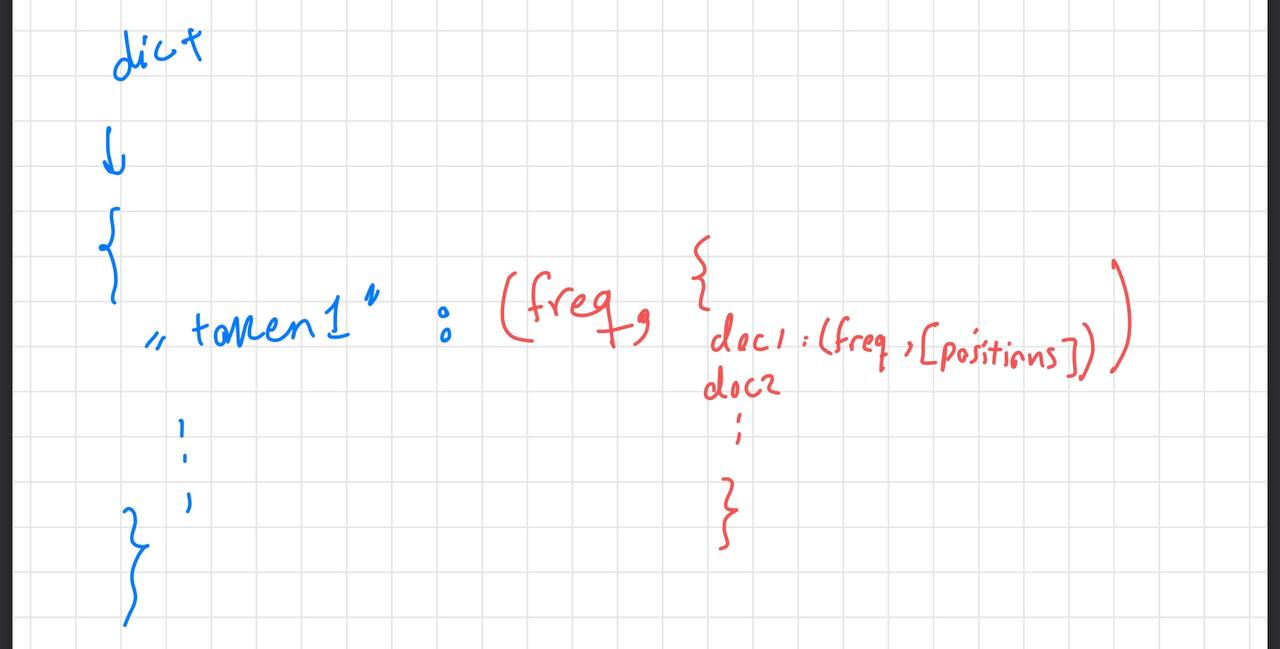

In [ ]:
def create_positional_inverted_index(data, num):
  positional_inverted_index = {}
  #IR_data_news.shape[1]
  for doc_id in range(num):
    news_tokens = preprocess_text(data[doc_id]['content'])
    for token_position, token in enumerate(news_tokens):
      if positional_inverted_index.get(token) is None:
        positional_inverted_index[token]= [1,{}]
        positional_inverted_index[token][1][doc_id] = [1,[token_position]]
      else:
        postings = positional_inverted_index[token][1].keys()
        if not already_in_postings_list(postings, doc_id):
          positional_inverted_index[token][0] += 1
          positional_inverted_index[token][1][doc_id] = [1, [token_position]]
        else:
          positional_inverted_index[token][0] += 1
          positional_inverted_index[token][1][doc_id][0]+=1
          positional_inverted_index[token][1][doc_id][1].append(token_position)
  return positional_inverted_index

        

In [ ]:
positional_index = create_positional_inverted_index(IR_data_news, IR_data_news.shape[1])

In [ ]:
# saving positional inverted index and preprocessed_news in colab
with open("positional_index.txt", "wb") as myFile:
    pickle.dump(positional_index, myFile)
with open("preprocessed_news.txt", "wb") as myFile2:
    pickle.dump(preprocessed_news, myFile2)

In [ ]:
# loading positional index from google drive
with open(positional_index_path, "rb") as myFile:
    saved_positional_index = pickle.load(myFile)
with open(preprocessed_news_path, "rb") as myFile:
    saved_preprocessed_news = pickle.load(myFile)

In [ ]:
def simple_query(query, positional_index):
  ranked_docs = {}
  query_tokens = preprocess_text(query)
  for token in query_tokens:
    if token in list(positional_index.keys()):
      docs = list(positional_index[token][1].keys())
      for i in docs:
        # token_frequency_in_doc = positional_index[token][1][i][0]
        # doc_length = preprocessed_news[i]
        # value = token_frequency_in_doc/doc_length
        if i not in list(ranked_docs.keys()):
          ranked_docs[i] = 1
        else:
          ranked_docs[i] += 1
  final = sorted(ranked_docs.items(), key=lambda item: item[1], reverse=True)
  # for i in final[:15]:
  #   print(IR_data_news[i[0]]['title'])
  #   print(IR_data_news[i[0]]['url'])
  return final[:100]

In [ ]:
simple_query('آلوده تهران شهر', saved_positional_index)

[(8282, 3),
 (9403, 3),
 (10169, 3),
 (10790, 3),
 (10968, 3),
 (11649, 3),
 (4788, 2),
 (6960, 2),
 (8981, 2),
 (9687, 2),
 (10286, 2),
 (10633, 2),
 (10852, 2),
 (11437, 2),
 (11457, 2),
 (11474, 2),
 (12038, 2),
 (12076, 2),
 (12154, 2),
 (8, 2),
 (16, 2),
 (48, 2),
 (55, 2),
 (56, 2),
 (64, 2),
 (89, 2),
 (163, 2),
 (275, 2),
 (277, 2),
 (278, 2),
 (299, 2),
 (320, 2),
 (350, 2),
 (352, 2),
 (372, 2),
 (387, 2),
 (412, 2),
 (478, 2),
 (495, 2),
 (552, 2),
 (568, 2),
 (575, 2),
 (588, 2),
 (697, 2),
 (717, 2),
 (758, 2),
 (767, 2),
 (797, 2),
 (819, 2),
 (821, 2),
 (843, 2),
 (866, 2),
 (886, 2),
 (888, 2),
 (916, 2),
 (940, 2),
 (1116, 2),
 (1167, 2),
 (1211, 2),
 (1241, 2),
 (1243, 2),
 (1273, 2),
 (1276, 2),
 (1306, 2),
 (1322, 2),
 (1386, 2),
 (1489, 2),
 (1526, 2),
 (1557, 2),
 (1565, 2),
 (1603, 2),
 (1624, 2),
 (1633, 2),
 (1647, 2),
 (1782, 2),
 (1959, 2),
 (1962, 2),
 (1976, 2),
 (1995, 2),
 (2014, 2),
 (2213, 2),
 (2219, 2),
 (2334, 2),
 (2366, 2),
 (2395, 2),
 (2398, 2),


In [ ]:
def simple_query_with_not(not_words, positional_index, retrived_docs):
  for not_word in not_words:
    for (i, j) in retrived_docs:
      if i in positional_index[not_word][1].keys():
        retrived_docs.remove((i,j))
  # for i in retrived_docs[:15]:
  #   print(IR_data_news[i[0]]['title'])
  #   print(IR_data_news[i[0]]['url'])
  return retrived_docs

In [ ]:
res = simple_query('آلوده شهر', saved_positional_index)

استانداران خود را مسئول تولید علم، فناوری و ثروت در کشور بدانند
https://www.farsnews.ir/news/14001221001163/استانداران-خود-را-مسئول-تولید-علم-فناوری-و-ثروت-در-کشور-بدانند
خطیب جمعه تهران: سازمان‌ همکاری اسلامی در برابر کشتار مردم یمن سکوت کرده است
https://www.farsnews.ir/news/14001108000202/خطیب-جمعه-تهران-سازمان‌-همکاری-اسلامی-در-برابر-کشتار-مردم-یمن-سکوت
فتنه 88؛ گناه نابخشودنی| خرداد پر از حادثه؛ دعوت به قانون‌گریزی در لفافه بیانیه‌های قانونمدارانه
https://www.farsnews.ir/news/14001002000543/فتنه-گناه-نابخشودنی|-خرداد-پر-از-حادثه-دعوت-به-قانون‌گریزی-در-لفافه
نباید مسائل روزمره دولت را از اصلاحات ساختاری باز بدارد/ دولت مگاپروژه‌ها را کلید بزند
https://www.farsnews.ir/news/14000915000397/نباید-مسائل-روزمره-دولت-را-از-اصلاحات-ساختاری-باز-بدارد-دولت
نماینده اتحادیه دانشجویان مستقل: دولت و مجلس فعلی میراث‌دار 8 سال جریان پرمدعا و بی‌عمل هستند
https://www.farsnews.ir/news/14000915000405/نماینده-اتحادیه-دانشجویان-مستقل-دولت-و-مجلس-فعلی-میراث‌دار-سال-جریان
آبان 98| شبیخون دولت اعتدال‌گرایا

In [ ]:
simple_query('آلوده شهر', saved_positional_index)

استانداران خود را مسئول تولید علم، فناوری و ثروت در کشور بدانند
https://www.farsnews.ir/news/14001221001163/استانداران-خود-را-مسئول-تولید-علم-فناوری-و-ثروت-در-کشور-بدانند
خطیب جمعه تهران: سازمان‌ همکاری اسلامی در برابر کشتار مردم یمن سکوت کرده است
https://www.farsnews.ir/news/14001108000202/خطیب-جمعه-تهران-سازمان‌-همکاری-اسلامی-در-برابر-کشتار-مردم-یمن-سکوت
فتنه 88؛ گناه نابخشودنی| خرداد پر از حادثه؛ دعوت به قانون‌گریزی در لفافه بیانیه‌های قانونمدارانه
https://www.farsnews.ir/news/14001002000543/فتنه-گناه-نابخشودنی|-خرداد-پر-از-حادثه-دعوت-به-قانون‌گریزی-در-لفافه
نباید مسائل روزمره دولت را از اصلاحات ساختاری باز بدارد/ دولت مگاپروژه‌ها را کلید بزند
https://www.farsnews.ir/news/14000915000397/نباید-مسائل-روزمره-دولت-را-از-اصلاحات-ساختاری-باز-بدارد-دولت
نماینده اتحادیه دانشجویان مستقل: دولت و مجلس فعلی میراث‌دار 8 سال جریان پرمدعا و بی‌عمل هستند
https://www.farsnews.ir/news/14000915000405/نماینده-اتحادیه-دانشجویان-مستقل-دولت-و-مجلس-فعلی-میراث‌دار-سال-جریان
آبان 98| شبیخون دولت اعتدال‌گرایا

[(6960, 2),
 (8282, 2),
 (9403, 2),
 (9687, 2),
 (10169, 2),
 (10790, 2),
 (10852, 2),
 (10968, 2),
 (11437, 2),
 (11649, 2),
 (2150, 1),
 (3014, 1),
 (4788, 1),
 (7032, 1),
 (7087, 1)]

In [ ]:
IR_data_news[10169]['url']

'https://www.farsnews.ir/news/14000915000405/نماینده-اتحادیه-دانشجویان-مستقل-دولت-و-مجلس-فعلی-میراث\u200cدار-سال-جریان'

In [ ]:
def check_nearby_positions(postions1, postions2):
  postions1_index = 0
  postions2_index = 0
  while postions1_index < len(postions1) and postions2_index < len(postions2):
    pos1 = postions1[postions1_index]
    pos2 = postions2[postions2_index]
    if pos2 == pos1 + 1:
      # print('pos1',pos1)
      # print('pos2',pos2)
      return True
    elif pos2 < pos1:
      postions2_index += 1
    else:
      postions1_index +=1 
  return False
      

In [ ]:
def phrase_query(phrase, saved_positional_index):
  #query_words = phrase.split(" ")
  query_words = preprocess_text(phrase)
  retrived_docs = []
  print(query_words)
  if (len(query_words)!=2):
    return[]
  if (query_words[0] in saved_positional_index.keys() and 
      query_words[1] in saved_positional_index.keys()):
    postings_lists1 = saved_positional_index[query_words[0]][1] # list of doc_id , posotiosn for term1
    postings_lists2 = saved_positional_index[query_words[1]][1] # list of doc_id , posotiosn for term2
    doc_index1 = 0 # iterates on postings_lists1
    doc_index2 = 0 # iterates on postings_lists2
    if postings_lists1 is not None and postings_lists1 is not None:
      # print(postings_lists1)
      # print(postings_lists2)
      while doc_index1 < len(postings_lists1) and doc_index2 < len(postings_lists2):
        doc_id1 = list(postings_lists1.items())[doc_index1][0]
        doc_id2 = list(postings_lists2.items())[doc_index2][0]
        if doc_id1 == doc_id2:
          # print(doc_id1)
          postions1 = postings_lists1[doc_id1][1]
          postions2 = postings_lists2[doc_id2][1]
          # print('positions1',postions1)
          # print('positions2',postions2)
          if check_nearby_positions(postions1,postions2):
            retrived_docs.append(doc_id1)
            #print('added')
          doc_index1 += 1
          doc_index2 += 1
        elif doc_id1 > doc_id2:
          doc_index2 += 1
        else:
          doc_index1 += 1
  else:
    print('hi')
  # for i in retrived_docs[:15]:
  #   print(IR_data_news[i]['title'])
  #   print(IR_data_news[i]['url'])
  return retrived_docs[:15]


In [ ]:
res = phrase_query(' کارگران', saved_positional_index)
print(res)

['حقوق', 'کارگر']
گزارش سفر رئیس‌جمهور به مازندران| رئیسی: برای حمایت از دهک‌های پایین برنامه‌ ویژه‌ای داریم
https://www.farsnews.ir/news/14001220000749/گزارش-سفر-رئیس‌جمهور-به-مازندران|-رئیسی-برای-حمایت-از-دهک‌های-پایین
رئیسی: دولت در مذاکرات از خطوط قرمز عقب‌نشینی نخواهد کرد
https://www.farsnews.ir/news/14001217000668/رئیسی-دولت-در-مذاکرات-از-خطوط-قرمز-عقب‌نشینی-نخواهد-کرد
رئیس‌جمهور: مردم اوکراین قربانی سیاست‌های شیطانی آمریکا شده‌اند
https://www.farsnews.ir/news/14001215001144/رئیس‌جمهور-مردم-اوکراین-قربانی-سیاست‌های-شیطانی-آمریکا-شده‌اند
رئیس‌جمهور: کسی که به کارگر ظلم می‌کند، صلاحیت ندارد پیمانکار دولت باشد
https://www.farsnews.ir/news/14001215000943/رئیس‌جمهور-کسی-که-به-کارگر-ظلم-می‌کند-صلاحیت-ندارد-پیمانکار-دولت-باشد
مهم‌ترین گام اصلاح نظام بودجه‌ریزی کنترل هزینه‌ها و ایجاد ردیف‌های پایدار درآمدی است
https://www.farsnews.ir/news/14001118000421/مهم‌ترین-گام-اصلاح-نظام-بودجه‌ریزی-کنترل-هزینه‌ها-و-ایجاد-ردیف‌های
گزارش سفر رئیس‌جمهور به گیلان/ پاسخ رئیسی به تماس تلفنی یکی از شهروند

In [ ]:
res = phrase_query('جزای نقدی ', saved_positional_index)


['جزا', 'نقدی']
محرومیت 2 عضو فوتبال و فوتسال بانوان توسط کمیته اخلاق
https://www.farsnews.ir/news/14001222000459/محرومیت-2-عضو-فوتبال-و-فوتسال-بانوان-توسط-کمیته-اخلاق
محرومیت دو مدیر فوتبالی از سوی کمیته اخلاق
https://www.farsnews.ir/news/14001212000304/محرومیت-دو-مدیر-فوتبالی-از-سوی-کمیته-اخلاق
یک مدیر فوتبالی 10 سال محروم شد
https://www.farsnews.ir/news/14001203000340/یک-مدیر-فوتبالی-0-سال-محروم-شد
منع کلیه فعالیت‌های دو بازیکن در فوتبال بانوان و مردان توسط کمیته اخلاق
https://www.farsnews.ir/news/14001120000710/منع-کلیه-فعالیت‌های-دو-بازیکن-در-فوتبال-بانوان-و-مردان-توسط-کمیته
واگذاری تمامی مراحل نقل و انتقال مالکیت خودرو به نیروی انتظامی
https://www.farsnews.ir/news/14001216000334/واگذاری-تمامی-مراحل-نقل-و-انتقال-مالکیت-خودرو-به-نیروی-انتظامی
مجازات اخلالگران نظام اقتصادی با مصوبه مجلس شدیدتر می‌شود
https://www.farsnews.ir/news/14001209000252/مجازات-اخلالگران-نظام-اقتصادی-با-مصوبه-مجلس-شدیدتر-می‌شود
کلیات طرح حمایت از کاربران فضای مجازی در کمیسیون ویژه تصویب شد
https://www.farsnews

In [ ]:
# simple + phrase + not
def query_analizer(query):
  simple_query = ""
  phrase_query= ""
  not_word = ""
  split1= query.split("!")
  not_word = split1[1].split(" ")[0]
  split2 = split1[0].split("'", 2)
  phrase_query = split2[1]
  simple_query = split2[0]+" "+split2[2]
  print(simple_query)
  return simple_query, phrase_query, not_word


In [ ]:
a,b,c = query_analizer("سلام مردم 'هوا' سلامتر!ایرانم")
print(c)

سلام مردم   سلامتر
ایرانم


In [ ]:
def complex_query(query):
  retrived_docs = []
  simpleQuery, phraseQuery, not_word = query_analizer(query)
  simple_docs = simple_query(simpleQuery, saved_positional_index)
  phrase_docs =  phrase_query(phraseQuery, saved_positional_index)
  not_docs = simple_query(not_word, saved_positional_index)
  simple_list = []
  not_list = []
  for i in simple_docs:
    simple_list.append(i[0])

  for i in not_docs:
    not_list.append(i[0])

  # print(simple_list)
  # print("******")
  # print(phrase_docs)
  # print("******")
  # print(not_docs)
  for i in simple_list:
    if i not in not_list:
      if i in phrase_docs:
        retrived_docs.append(i)
  return retrived_docs

In [ ]:
phrase_query("نگون بخت", saved_positional_index)

['نگون', 'بخت']


[10278]

In [ ]:
IR_data_news[10278]['url']

'https://www.farsnews.ir/news/14000912000414/ماجرای-هماهنگی-با-حاکم-بلوچستان-پاکستان-برای-آزادی-گروگان\u200c\u200cهای-گروهک'

In [ ]:
complex_query("تردستی 'حساب کتاب' !کرونا ")

تردستی   
['حساب', 'کتاب']
دبیر: وزیر مرا برکنار کند دستش را هم می‌بوسم/برای حال‌گیری بودجه خادم را کم کردند
https://www.farsnews.ir/news/14001222000392/دبیر-وزیر-مرا-برکنار-کند-دستش-را-هم-می‌بوسم-برای-حال‌گیری-بودجه-خادم
اسکوچیچ: مردم متوجه شده‌اند که می‌توانند هدایت تیم ملی را به من واگذار کنند/هاشمیان سواد اروپایی از فوتبال دارد
https://www.farsnews.ir/news/14001222000329/اسکوچیچ-مردم-متوجه-شده‌اند-که-می‌توانند-هدایت-تیم-ملی-را-به-من-واگذار
آجورلو: برای گرفتن حق و حقوقمان یقه پاره می کنیم/ فردا پایان خط فقر فوتبال ماست
https://www.farsnews.ir/news/14001214000404/آجورلو-برای-گرفتن-حق-و-حقوقمان-یقه-پاره-می-کنیم-فردا-پایان-خط-فقر
رئیس سازمان خصوصی سازی: استقلال و پرسپولیس تاریکخانه دارند/اعلام بدهی فوق سنگین مالیاتی سرخابی‌ها
https://www.farsnews.ir/news/14001207000228/رئیس-سازمان-خصوصی-سازی-استقلال-و-پرسپولیس-تاریکخانه-دارند-اعلام-بدهی
انتقال مالکیت تراکتور و ماشین سازی محلی برای مجادله نمایندگان تبریز و کرمان/ رویای پرشورها عملی می شود؟
https://www.farsnews.ir/news/14001029000369/انت

[]